# The Planar Laplace mechanism

Here we implement the planar laplace mechanism to add laplace noise to any given 2d-coordinates. It's worth noting that polar coordinates are used to generate random laplace noise. In order to randomly draw r, we use the inverse CDF of r which is $$C_{\epsilon}(r) = \int_{0}^{r} D_{\epsilon, R} (\rho) d\rho = 1 - (1 + \epsilon r)e^{-\epsilon r}$$ as calculated in https://hal.inria.fr/hal-01114241/file/paper.pdf

In [6]:
import random
from scipy import special
import scipy
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [7]:
def random_laplace_noise(eps):
    '''
    Given epsilon > 0, this function returns relative 
    coordinates of the generated laplace noise, which 
    follows a planer laplace distribution centered at
    x with epsilon as the scale.
    '''
    # generate polar coordinates
    theta = np.random.uniform(0, 2*math.pi) # this shall be the angular coordinate
    
    p = random.random() # draw a random sample from unif(0, 1)
    r = -1/eps * (scipy.special.lambertw((p-1)/math.e, k=-1, tol=1e-8).real + 1) #this shall be the radial coordinate
    
    # convert polar coordinates to cartesian coordinates
    x, y = r * math.cos(theta), r * math.sin(theta)
    
    return x, y

## A Quick Demo

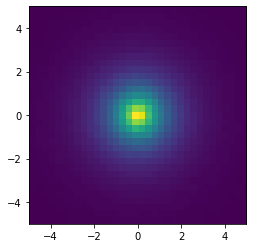

In [8]:
# Verify our algorithm using monte carlo simulation.

x_list = []
y_list = []
eps = 1

for i in range(10**6):
    noise = random_laplace_noise(eps)
    x_list.append(noise[0])
    y_list.append(noise[1])
    
# Use heatmap to visualize the distribution of generated laplace noise
heatmap, xedges, yedges = np.histogram2d(x_list, y_list, bins=100)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.show()

# Geo-Indistinguishable Mechanisms of Optimal Utility

\begin{align*}
Minimize:\ &\sum_{x,z\in \mathcal{X}} \pi_x k_{xz} d_Q(x, z) \\
Subject\ to:\ &k_{xz} \leq e^{\epsilon d_{\mathcal{X}}(x, x')} k_{x' z} &x,x',z\in \mathcal{X} \tag{1}\\
&\sum_{z\in \mathcal{X}} k_{xz} = 1 & x\in \mathcal{X} \tag{2}\\
&k_{xz} \geq 0 &x, z\in \mathcal{X} \tag{3}
\end{align*}

In [9]:
import gurobipy as gp
from gurobipy import GRB

In [10]:
# We use euclidean distance to simplify the computation. 
# metrics such as manhattan distance and calculation methods such as 
# haversine formula can be used to substitute this function.
def dist(pt1, pt2):
    x_diff = pt1[0] - pt2[0]
    y_diff = pt1[1] - pt2[1]
    return math.sqrt(pow(x_diff, 2) + pow(y_diff, 2))

In [11]:
def optql(x_list, pi_list, dQ, epsilon=0.5):
    '''
    input: x_list: list of geographic coordinates
           pi_list: probability distribution for x_list
           dQ: distance metric
           epsilon: desired privacy level
    
    output: matrix: stochastic transition matrix
            pre_prob: normalized pre-process probability distribution
            post_prob: post-process probability distribution
    '''
    
    pre_prob = np.array(pi_list) / sum(pi_list) # normalize probability distribution
    n = len(x_list) # get number of elements
    threshold = math.exp(epsilon)
    
    # define a model
    model = gp.Model('OptQL')
    
    # add variables accessed as (0, 0), (0, 1), (1, 1), ...
    variables = model.addVars(n, n, lb=0.0, ub=1.0, name='k')
    
    # set objective function
    model.setObjective(gp.quicksum(pre_prob[i] * variables[i, j] * dQ(x_list[i], x_list[j]) \
                                   for i in range(n) for j in range(n)), GRB.MINIMIZE)
    
    # add constraints (1)
    model.addConstrs(variables[i, k] <= pow(threshold, dQ(x_list[i], x_list[j])) * variables[j, k] \
                     for i in range(n) for j in range(n) for k in range(n))
    
    # add constraints (2)
    model.addConstrs(gp.quicksum(variables.select(i, '*')) == 1 for i in range(n))
    
    # constriants (3) are already satisfied
    
    # optimize the model
    model.optimize()
    
    # build a matrix to store the stochastic matrix
    variables = model.getAttr('x', variables)
    matrix = np.zeros((n, n))
    for key, value in variables.items():
        matrix[key] = value
    
    # get post-process probability distribution
    post_prob = pre_prob @ matrix
    
    
    return matrix, pre_prob, post_prob

## A Quick Demo

In [24]:
import plotly.figure_factory as ff
import pandas as pd
import geopandas as gpd
import osmnx as ox

In [25]:
all_zones = gpd.read_file('data/ZIP_Codes.geojson')
all_zones['Centroids'] = all_zones['geometry'].apply(lambda x: x.centroid)
sample = all_zones[:10]

In [33]:
x_list = [(lon, lat) for (lon, lat) in sample['Centroids'].apply(lambda x: (x.xy[0][0], x.xy[1][0]))]
pi_list = [geometry.area for geometry in sample['geometry']]
#pi_list = [1 for _ in range(len(x_list))]
dQ = lambda *args: dist(*args) * 69 # approximately convert distance between (lon, lat) coordinates to meters
epsilon = 0.095

p_matrix, pre_prob, post_prob = optql(x_list, pi_list, dQ, epsilon=epsilon)

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1010 rows, 100 columns and 1900 nonzeros
Model fingerprint: 0x04c70a0f
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [3e-05, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 100 rows and 0 columns
Presolve time: 0.02s
Presolved: 910 rows, 100 columns, 1900 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   8.100000e+01   0.000000e+00      0s
      85    2.1728183e+00   0.000000e+00   0.000000e+00      0s

Solved in 85 iterations and 0.04 seconds
Optimal objective  2.172818264e+00


In [36]:
import branca
import branca.colormap as cm
import folium

def reversed_colormap(existing):
    return cm.LinearColormap(
        colors=list(reversed(existing.colors)),
        vmin=existing.vmin, vmax=existing.vmax
    )
step = branca.colormap.linear.RdYlGn_10.to_step(6).scale(0, pre_prob.max()) 
step = reversed_colormap(step)
step.caption = 'Color Scale'

m = folium.Map(location=[42.36, -71.06], zoom_start=11.5, tiles='CartoDBpositron')

tmp = sample.copy(deep=True).drop('Centroids', axis=1)
tmp['pre_prob'] = pre_prob
folium.GeoJson(
    tmp,
    style_function=lambda feature: {
        'fill': True,
        'weight': 1,
        'opacity':1,
        'color': step(feature['properties']['pre_prob'])
    }
).add_to(m)
step.add_to(m)

m

In [37]:
step = branca.colormap.linear.RdYlGn_10.to_step(6).scale(0, post_prob.max()) 
step = reversed_colormap(step)
step.caption = 'Color Scale'

m = folium.Map(location=[42.36, -71.06], zoom_start=11.5, tiles='CartoDBpositron')

tmp = sample.copy(deep=True).drop('Centroids', axis=1)
tmp['post_prob'] = post_prob
folium.GeoJson(
    tmp,
    style_function=lambda feature: {
        'fill': True,
        'weight': 1,
        'opacity':1,
        'color': step(feature['properties']['post_prob'])
    }
).add_to(m)
step.add_to(m)

m

In [39]:
prob_diff = post_prob - pre_prob
step = branca.colormap.linear.RdYlGn_10.to_step(6).scale(prob_diff.min(), prob_diff.max()) 
step = reversed_colormap(step)
step.caption = 'Probability Difference (Post - Pre)'

m = folium.Map(location=[42.36, -71.06], zoom_start=11.5, tiles='CartoDBpositron')

tmp = sample.copy(deep=True).drop('Centroids', axis=1)
tmp['prob_diff'] = prob_diff
folium.GeoJson(
    tmp,
    style_function=lambda feature: {
        'fill': True,
        'weight': 1,
        'opacity':1,
        'color': step(feature['properties']['prob_diff'])
    }
).add_to(m)
step.add_to(m)

m

In [21]:
n = len(x_list)
dist_matrix = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        dist_matrix[i, j] = dQ(x_list[i], x_list[j])

<AxesSubplot:>

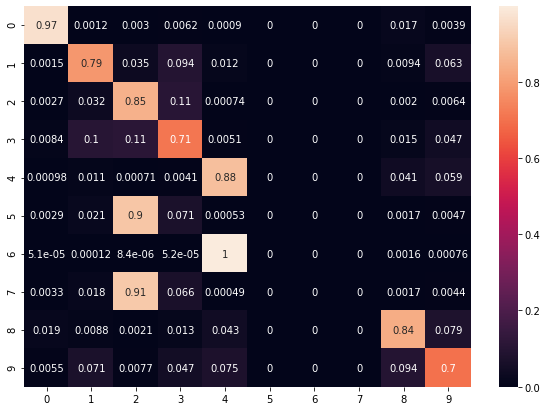

In [22]:
plt.figure(figsize=(10, 7))
sns.heatmap(p_matrix, annot=True)

<AxesSubplot:>

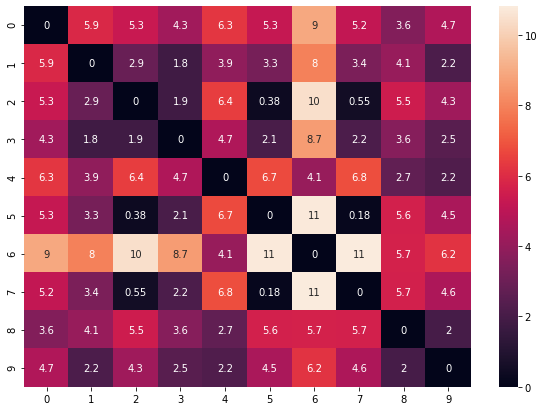

In [23]:
plt.figure(figsize=(10, 7))
sns.heatmap(dist_matrix, annot=True)